<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

## About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-07-20 17:27:49--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.01s   

2020-07-20 17:27:49 (1.66 MB/s) - ‘loan_train.csv’ saved [23101/23101]



## Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.shape

(346, 10)

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [8]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



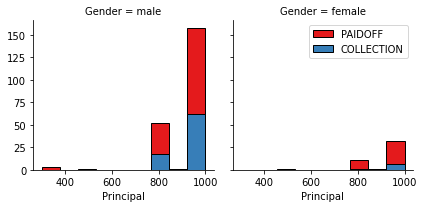

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

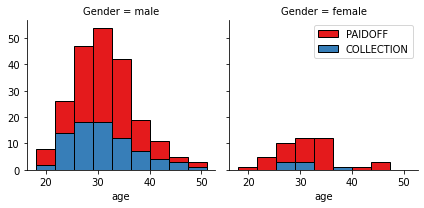

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

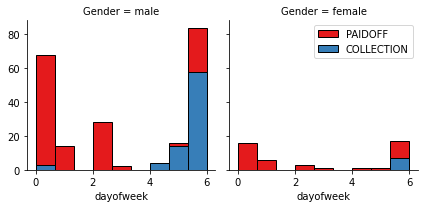

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

## Pre-processing:  Feature selection/extraction

Lets look at the day of the week people get the loan 

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


### Convert Categorical features to numerical values

Lets look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


### One Hot Encoding  


In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
# display the columns to be encoded
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Define feature sets, X:

In [18]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

In [19]:
X = Feature
X.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [20]:
y = df['loan_status'].values

In [21]:
# encode the target variables
df_encoded = df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value = [0,1],inplace = False)
y = df_encoded.values
y[0:5]

array([1, 1, 1, 1, 1])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [22]:
## split data into training and test set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)

In [23]:
# Normalize the training set
feature_normalizer = preprocessing.StandardScaler()
X_train = feature_normalizer.fit(X_train).transform(X_train)
X_train[:5]

array([[ 0.52213029,  0.91193022, -1.16277441, -0.38330071,  0.83918136,
        -0.39735971, -0.84635221,  1.13270423],
       [ 0.52213029,  0.91193022, -0.67649894, -0.38330071,  0.83918136,
        -0.39735971,  1.1815412 , -0.882843  ],
       [-1.43687018, -0.97751424, -0.51440711, -0.38330071, -1.19163753,
        -0.39735971,  1.1815412 , -0.882843  ],
       [ 0.52213029, -0.97751424,  1.10651113, -0.38330071, -1.19163753,
        -0.39735971,  1.1815412 , -0.882843  ],
       [ 0.52213029,  0.91193022,  0.45814383, -0.38330071,  0.83918136,
        -0.39735971, -0.84635221,  1.13270423]])

In [24]:
# Normalize the validation set
X_val = feature_normalizer.transform(X_val)
X_val[:5]

array([[ 0.52213029,  0.91193022,  1.10651113, -0.38330071,  0.83918136,
         2.51661148, -0.84635221, -0.882843  ],
       [ 0.52213029, -0.97751424,  0.45814383, -0.38330071, -1.19163753,
        -0.39735971,  1.1815412 , -0.882843  ],
       [ 0.52213029,  0.91193022, -0.51440711, -0.38330071,  0.83918136,
         2.51661148, -0.84635221, -0.882843  ],
       [ 0.52213029, -1.98521796, -0.02813164, -0.38330071, -1.19163753,
        -0.39735971, -0.84635221,  1.13270423],
       [ 0.52213029, -0.97751424,  1.43069478, -0.38330071,  0.83918136,
        -0.39735971,  1.1815412 , -0.882843  ]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

### 1. K Nearest Neighbor(KNN)
The model with the best accuracy is determined by splitting the training dataset into a training and validation set and using the latter to test the model using different hyperparameters

In [25]:
#import the K neighbor library
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import jaccard_score

In [26]:
# create empty list for n_neighbors
n_neighbors = []

# create empty list for accuracies
accuracy_val = []
accuracy_train = []

# define maximum nearest neighbors
max_nearest_neighbors = 20

for k in np.arange(1,max_nearest_neighbors,1):
    n_neighbors.append(k)
    
    # train the model 
    knn_clf = KNeighborsClassifier(n_neighbors = k)
    
    # fit classifier on training data
    knn_clf.fit(X_train,y_train)
    
    # make a prediction on validation data
    knn_yhat = knn_clf.predict(X_val)
    
    # evaluate the accuracy classification score 
    accuracy_train.append(accuracy_score(y_train, knn_clf.predict(X_train)))
    accuracy_val.append(accuracy_score(y_val, knn_yhat))
    

Figure 1.  Accuracy score for different K hyperparameter


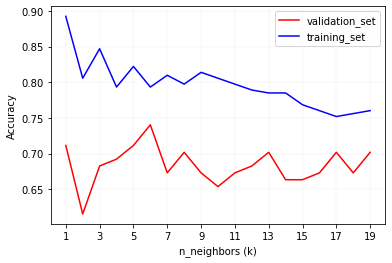

In [27]:
#plot the accuracy for the various k values
import matplotlib.pyplot as plt
print('\033[1m'+ 'Figure 1.' +'\033[0m',' Accuracy score for different K hyperparameter')

plt.plot(n_neighbors,accuracy_val,  color ='red', label = 'validation_set')
plt.plot(n_neighbors,accuracy_train,  color ='blue', label = 'training_set')
plt.xlabel('n_neighbors (k)')
plt.ylabel('Accuracy')
plt.grid(color = 'lightgray', linestyle='-', linewidth = 0.3, alpha=0.5)
plt.xticks(np.arange(1, max_nearest_neighbors, step = 2))
plt.legend()
plt.show()

In [28]:
# summarize results
print('\033[1m'+ 'K Nearest Neighbor RESULT SUMMARY' +'\033[0m\n')

# identify the k_value with maxiumum accuracy accuracy 
n_neighbors = n_neighbors[np.argmax(accuracy_val)]

knn_clf_optimal = KNeighborsClassifier(n_neighbors = n_neighbors)
print(f'K Nearest Neighbor parameters:{knn_clf_optimal.get_params()}\n')

# accuracy score for training and validation
print("Accuracy for training set: {:.4f}".format(knn_clf.score(X_train, y_train)))
print("Accuracy for validation set: {:.4f}".format(knn_clf.score(X_val, y_val)))

# f1 score for training and validation
print (f"f1_score for training set: :{f1_score(y_train, knn_clf.predict(X_train), average='weighted'): 0.4f}") 
print (f"f1_score for validation set:{f1_score(y_val, knn_yhat, average='weighted'): 0.4f}\n") 


K Nearest Neighbor RESULT SUMMARY

K Nearest Neighbor parameters:{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 6, 'p': 2, 'weights': 'uniform'}

Accuracy for training set: 0.7603
Accuracy for validation set: 0.7019
f1_score for training set: : 0.7445
f1_score for validation set: 0.6872



### 2. Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate decision tree object
clf_decision_tree = DecisionTreeClassifier()
print(f'Decision Tree parameters:{clf_decision_tree .get_params()}\n')

# fit classifier on training data
model_decision_tree = clf_decision_tree.fit(X_train,y_train)

# predict on the validation data
yhat_DT = model_decision_tree.predict(X_val)

Decision Tree parameters:{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}



In [30]:
# summarize results
print('\033[1m'+ 'Decision Tree RESULT SUMMARY' +'\033[0m\n')

# accuracy score for training and validation
print("Accuracy for training set: {:.4f}".format(clf_decision_tree.score(X_train, y_train)))
print("Accuracy for validation set: {:.4f}".format(clf_decision_tree.score(X_val, y_val)))

# f1 score for training and validation
print (f"f1_score for training set: :{f1_score(y_train, clf_decision_tree.predict(X_train), average='weighted'): 0.4f}") 
print (f"f1_score for validation set:{f1_score(y_val, yhat_DT, average='weighted'): 0.4f}\n") 


Decision Tree RESULT SUMMARY

Accuracy for training set: 0.9050
Accuracy for validation set: 0.6538
f1_score for training set: : 0.9072
f1_score for validation set: 0.6773



### 3. Support Vector Machine

In [31]:
# import svm library
from sklearn import svm

In [32]:
# SVM to produce model using training set
clf_svm = svm.SVC(C=1.0)
print(f'Support Vector Machine parameters:{clf_svm .get_params()}\n')

# fit classifier on training data
model_svm = clf_svm.fit(X_train,y_train)

# predict on the validation data
yhat_svm = clf_svm.predict(X_val)

Support Vector Machine parameters:{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}



In [33]:
# summarize results
print('\033[1m'+ 'Support Vector Machine RESULT SUMMARY' +'\033[0m\n')

# accuracy score for training and validation
print("Accuracy for training set: {:.4f}".format(clf_svm .score(X_train, y_train)))
print("Accuracy for validation set: {:.4f}".format(clf_svm .score(X_val, y_val)))

# f1 score for training and validation
print (f"f1_score for training set: :{f1_score(y_train, clf_svm .predict(X_train), average='weighted'): 0.4f}") 
print (f"f1_score for validation set:{f1_score(y_val, yhat_svm, average='weighted'): 0.4f}\n") 

Support Vector Machine RESULT SUMMARY

Accuracy for training set: 0.7851
Accuracy for validation set: 0.7115
f1_score for training set: : 0.7671
f1_score for validation set: 0.6939



### 4. Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

clf_LR = LogisticRegression(solver = 'liblinear')
print(f'Logistic Regression parameters:{clf_LR .get_params()}\n')

# fit classifier on training data
clf_LR.fit(X_train,y_train)

# predict on the validation data
yhat_LR = clf_LR.predict(X_val)

# predict on the validation data
yhat_prob = clf_LR.predict_proba(X_val)

Logistic Regression parameters:{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}



In [35]:
# summarize results
print('\033[1m'+ 'Logistic Regression RESULT SUMMARY' +'\033[0m\n')

# accuracy score for training and validation
print("Accuracy for training set: {:.4f}".format(clf_LR.score(X_train, y_train)))
print("Accuracy for validation set: {:.4f}".format(clf_LR.score(X_val, y_val)))

# f1 score for training and validation
print (f"f1_score for training set: :{f1_score(y_train, clf_LR.predict(X_train), average='weighted'): 0.4f}") 
print (f"f1_score for validation set:{f1_score(y_val, yhat_LR, average='weighted'): 0.4f}\n") 

#compute jaccard index 
# jaccard_score(y_test, yhat_LR1)

#compute log loss
from sklearn.metrics import log_loss
log_loss = log_loss(y_val, yhat_prob)

print(f"Log loss:{log_loss: 0.4f}\n") 

Logistic Regression RESULT SUMMARY

Accuracy for training set: 0.7603
Accuracy for validation set: 0.6923
f1_score for training set: : 0.7518
f1_score for validation set: 0.6923

Log loss: 0.5365



# Model Evaluation using Test set

In [36]:
#import required libraries
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report

First, download and load the test set:

In [37]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-07-20 17:28:17--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-07-20 17:28:17 (96.5 MB/s) - ‘loan_test.csv’ saved [3642/3642]



## A. Load Test set for evaluation 

In [38]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [39]:
#convert style of dat from dd/mmyyy to dd-mm-yyyy
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-08,2016-10-07,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-08,2016-09-22,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-09,2016-10-08,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-09,2016-10-08,29,Bechalor,male


## B. Data Pre-processing

The test data is preprocessed to be used for Machine Learning algorithm. The strings are transformed to binary and dates provided to effective date (days of the week) to determine the time of loan. The features and target values are isoolated and defined for the algorithm.

In [40]:
# display the frequency of the target variable
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [41]:
# transform loan date to days of the week
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-08,2016-10-07,35,Master or Above,male,3,0
2,21,21,PAIDOFF,1000,30,2016-09-08,2016-09-22,43,High School or Below,female,3,0
3,24,24,PAIDOFF,1000,30,2016-09-09,2016-10-08,26,college,male,4,1
4,35,35,PAIDOFF,800,15,2016-09-09,2016-10-08,29,Bechalor,male,4,1


In [42]:
# convert the feature (gender) to binary
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-08,2016-10-07,35,Master or Above,0,3,0
2,21,21,PAIDOFF,1000,30,2016-09-08,2016-09-22,43,High School or Below,1,3,0
3,24,24,PAIDOFF,1000,30,2016-09-09,2016-10-08,26,college,0,4,1
4,35,35,PAIDOFF,800,15,2016-09-09,2016-10-08,29,Bechalor,0,4,1


In [43]:
#convert the education to binary
#education = pd.get_dummies(test_df['education'])

In [44]:
# merge all features to the encoded education
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature, pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

# define the features as Xf_test
Xf_test = Feature
Xf_test[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,0,0,0,0
2,1000,30,43,1,0,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


Apply normalization to the features using the normalizer (mean and standard deviation) from the training data set

In [45]:
# Normalize features for test data
Xf_test = feature_normalizer.transform(Xf_test)

In [46]:
# define target as yf_test
yf_test = test_df['loan_status'].values

# encode the target variables to binary format
test_df_encoded = test_df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value = [0,1],inplace = False)
yf_test = test_df_encoded.values
yf_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [47]:
# check that the number of data for target and feature variables are equal
len(yf_test) == len(Xf_test) 

True

## C. Evaluate on test data

### 1.  K Nearest Neighbor

In [48]:
# Compute the evaluation metrics for logistic regression
print("K NEAREST NEIGHBOR")

# make prediction of test data
yhat_knn = knn_clf.predict(Xf_test)

#print f1 score & jaccard index(model accuracy)
print (f"f1_score: {f1_score(yf_test, yhat_knn, average = 'weighted'):0.4f}")
print(f'Jaccard score: {jaccard_score(yf_test, yhat_knn):0.4f}')


# display the classification report
labels = ['COLLECTION', 'PAIDOFF']
print(f'classification report:\n {classification_report(yhat_knn, yf_test, target_names = labels)}')

K NEAREST NEIGHBOR
f1_score: 0.7007
Jaccard score: 0.7255
classification report:
               precision    recall  f1-score   support

  COLLECTION       0.21      0.50      0.30         6
     PAIDOFF       0.93      0.77      0.84        48

    accuracy                           0.74        54
   macro avg       0.57      0.64      0.57        54
weighted avg       0.85      0.74      0.78        54



### 2. Decision Tree

In [49]:
# Compute the evaluation metrics for logistic regression
print("DECISION TREE")

#predict the target for test data
yhat_decision_tree = clf_decision_tree.predict(Xf_test)

#print f1 score & jaccard index (model accuracy)print("DECISION TREE")
print(f'Jaccard score: {jaccard_score(yf_test, yhat_decision_tree):0.4f}')
print (f"f1_score: {f1_score(yf_test, yhat_decision_tree , average ='weighted'):0.4f}")

# display the classification report
labels = ['COLLECTION', 'PAIDOFF']
print(f'\nclassification report:\n {classification_report(yhat_decision_tree, yf_test, target_names = labels)}')

DECISION TREE
Jaccard score: 0.5106
f1_score: 0.5989

classification report:
               precision    recall  f1-score   support

  COLLECTION       0.50      0.30      0.38        23
     PAIDOFF       0.60      0.77      0.68        31

    accuracy                           0.57        54
   macro avg       0.55      0.54      0.53        54
weighted avg       0.56      0.57      0.55        54



### 3. SVM 

In [50]:
# Compute the evaluation metrics for support vector machine 
print("SUPPORT VECTOR MACHINE")

# make prediction of test data
yhat_SVM = clf_svm.predict(Xf_test)

# compute f1 score & jaccard index 
print (f"Jaccard: {jaccard_score(yf_test, yhat_SVM): 0.4f}")
print (f"f1_score:{f1_score(yf_test, yhat_SVM, average='weighted'): 0.4f}") 

# display the classification report
labels = ['COLLECTION', 'PAIDOFF']
print(f'\nclassification report:\n {classification_report(yhat_SVM, yf_test, target_names = labels)}')

SUPPORT VECTOR MACHINE
Jaccard:  0.7551
f1_score: 0.7552

classification report:
               precision    recall  f1-score   support

  COLLECTION       0.36      0.62      0.45         8
     PAIDOFF       0.93      0.80      0.86        46

    accuracy                           0.78        54
   macro avg       0.64      0.71      0.66        54
weighted avg       0.84      0.78      0.80        54



### 4. Logistic Regression

In [51]:
# Compute the evaluation metrics for logistic regression
print("LOGISTIC REGRESSION")

# predict the class for test set
yhat_logistic = clf_LR.predict(Xf_test) 

# compute jaccard index                                   
print (f"Jaccard: {jaccard_score(yf_test, yhat_logistic): 0.4f}")               

# compute the F-score
yhat_prob_test = clf_LR.predict_proba(Xf_test)
print (f"f1_score:{f1_score(yf_test, yhat_logistic, average='weighted'): 0.4f}") 

# compute the logloss
print (f"LogLoss: {log_loss(yf_test, yhat_prob_test): 0.4f}")  

# display the classification report
print(f'\nclassification report:\n {classification_report(yhat_logistic, yf_test, target_names = labels)}')

LOGISTIC REGRESSION
Jaccard:  0.5714
f1_score: 0.6224
LogLoss:  0.6195

classification report:
               precision    recall  f1-score   support

  COLLECTION       0.36      0.29      0.32        17
     PAIDOFF       0.70      0.76      0.73        37

    accuracy                           0.61        54
   macro avg       0.53      0.53      0.52        54
weighted avg       0.59      0.61      0.60        54



# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.7007  | 0.7255   | NA      |
| Decision Tree      | 0.5106  | 0.5989   | NA      |
| SVM                | 0.7551  | 0.7552   | NA      |
| LogisticRegression | 0.5714  | 0.6224   | 0.6195  |

**Discussion**

The hyperpparameters for the selected algorithms could be optimized to increase the accuracy of the validation and test data using GridSearch and Pipeline. However, for simplicity purpose and to adhere to the assignment requirement, this was not implemented for this project. 


From this result, Support Vector Machine gives the highest accuracy and F1 score 

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>